<a href="https://colab.research.google.com/github/Solf19/CNN/blob/main/CNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision
path_data = 'MyDrive/Progetto Deep/Data/'
path_mount = '/content/drive/'

from google.colab import drive
drive.mount('/content/drive')

subject = 'CNN1'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [ ]:
input_dim = 28*28
hidden_dim = 10
out_dim = 10


class ConvolutionalNetwork(nn.Module):

  def __init__(self, input_dim, out_dim):

    super(ConvolutionalNetwork, self).__init__()
    # Convolutional Neural Network Layer
    self.convolutaional_neural_network_layers = nn.Sequential(
                            nn.Conv2d(in_channels=1, out_channels=5, kernel_size=(3,3), padding=1, stride=1), # (N, 1, 28, 28)
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
                            nn.Conv2d(in_channels=5, out_channels=5, kernel_size=(3,3), padding=1, stride=1),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

    # Linear layer
    self.linear_layers = nn.Sequential(
                nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
                nn.Linear(in_features=5*7*7, out_features=out_dim),
        )

    #Softmax
    self.soft = nn.Softmax(dim=1)


  # Defining the forward pass
  def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the linear layer
        x = self.linear_layers(x)

        x = self.soft(x)

        return x

In [ ]:
model = ConvolutionalNetwork(input_dim, out_dim).to(device)

if device.type != "cpu":
  model = torch.compile(model)
else:
  model = torch.compile(model, mode = "max-autotune-no-cudagraphs", dynamic=True)


In [ ]:
loss_function = nn.CrossEntropyLoss()

In [ ]:
def accuracy(y_pred, y):

  pred = y_pred.detach().argmax(dim=1)
  corrects = (pred == y)

  accuracy = (corrects.sum()/corrects.size(0)).float()

  return accuracy

def evaluate(model, train_loader, test_loader):

  # initialize the accuracy as 0

  acc_train, acc_test = 0, 0

  with torch.no_grad():

    for x_train, y_train in train_loader:

      x_train, y_train = x_train.to(device), y_train.to(device)        # remember that we need to load our data into the GPUs

      out = model(x_train).squeeze()
      acc_train += accuracy(out, y_train)

    for x_test, y_test in test_loader:

      x_test, y_test = x_test.to(device), y_test.to(device)

      out = model(x_test).squeeze()
      acc_test += accuracy(out, y_test)

    acc_train, acc_test = acc_train / len(train_loader), acc_test / len(test_loader)

  return float(acc_train.detach()) * 100, float(acc_test.detach()) * 100

def train(model, x, y):

  out = model(x)
  loss = loss_function(out.squeeze(), y)

  optimizer.zero_grad()
  loss.backward()

  optimizer.step()
  return float(loss)

if device.type != "cpu":
  accuracy = torch.compile(accuracy)
  train = torch.compile(train)
else:
  accuracy = torch.compile(accuracy, mode = "max-autotune-no-cudagraphs", dynamic=True)
  train = torch.compile(train, mode = "max-autotune-no-cudagraphs", dynamic=True)


In [ ]:
class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
    self.patience = patience       # Number of epochs to wait for improvement
    self.delta = delta             # Minimum change in monitored metric to qualify as improvement
    self.verbose = verbose         # If True, print a message when validation metric improves
    self.path = path               # Path to save the model checkpoint
    self.counter = 0               # Counter to track epochs without improvement
    self.best_score = None         # Best validation metric achieved so far
    self.early_stop = False        # Flag to indicate whether to stop training

  def __call__(self, val_metric, model):
    if self.best_score is None:
      self.best_score = val_metric
      self.save_checkpoint(model)
    elif val_metric > self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
        print(f'Epochs without improvement: {self.counter}')
      if self.counter >= self.patience:
                self.early_stop = True
    else:
      self.best_score = val_metric
      self.save_checkpoint(model)
      self.counter = 0

  def save_checkpoint(self, model):
    torch.save(model.state_dict(), self.path)


In [ ]:
! mkdir /content/.checkpoints

mkdir: cannot create directory ‘/content/.checkpoints’: File exists


In [ ]:
n_train = 8000
n_test = 500
ratio = 12

batch_size_train = 300
batch_size_test = n_test

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
## TEST SET

dataset_test =  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=transform)

dataset_test.data, dataset_test.targets = dataset_test.data[:n_test], dataset_test.targets[:n_test]

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size_test, shuffle = False)


In [ ]:

train_losses = []
train_accuracies = []
test_accuracies = []



for i in range (1,ratio):
  ## TRAIN SET

  n_train_loop = int(n_train * i / ratio)

  #batch_size_train_loop = int(batch_size_train * i / ratio)
  dataset_train = torchvision.datasets.MNIST('./files/', train=True, download=True,
                          transform=transform)
  dataset_train.data, dataset_train.targets = dataset_train.data[:n_train_loop], dataset_train.targets[:n_train_loop]

  train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size_train,
                                              shuffle = True,  drop_last = True)
  EPOCHS = 101


  #model = ConvolutionalNetwork(input_dim, out_dim).to(device)
  learning_rate = 0.1
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
  early_stopping = EarlyStopping(patience=4, verbose=True, path='/content/.checkpoints/model_checkpoint.pt')
  for epoch in range(1,EPOCHS):

    train_loss = 0

    ## TRAIN STEP

    for x_train, y_train in train_loader:

      x_train, y_train = x_train.to(device), y_train.to(device)


      loss = train(model, x_train, y_train)

      train_loss += loss

    train_loss /= len(train_loader)                    # we divide by the number of batches
    train_losses.append(train_loss)

    ## TEST STEP

    if epoch % 100 == 0:

      train_acc, test_acc = evaluate(model, train_loader, test_loader)

      train_accuracies.append(train_acc)
      test_accuracies.append(test_acc)
      print("Epoch:", epoch, "Loss:", float(train_loss), "data:", len(dataset_train.data), "train_acc", train_acc, "test_acc", test_acc)


    if early_stopping.early_stop:
      train_acc, test_acc = evaluate(model, train_loader, test_loader)

      train_accuracies.append(train_acc)
      test_accuracies.append(test_acc)
      print("Early stopping triggered.")
      break




No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
W0530 08:29:38.371000 136689439051776 torch/_logging/_internal.py:1013] [2/0] Profiler function <class 'torch.autograd.profiler.record_function'> will be ignored


Epoch: 100 Loss: 1.8314761519432068 data: 666 train_acc 65.99999666213989 test_acc 59.3999981880188
Epoch: 100 Loss: 1.6554357707500458 data: 1333 train_acc 81.5833330154419 test_acc 76.80000066757202
Epoch: 100 Loss: 1.5247490207354228 data: 2000 train_acc 94.33333277702332 test_acc 90.6000018119812


W0530 08:34:52.337000 136689439051776 torch/_dynamo/convert_frame.py:357] torch._dynamo hit config.cache_size_limit (8)
W0530 08:34:52.337000 136689439051776 torch/_dynamo/convert_frame.py:357]    function: 'step' (/usr/local/lib/python3.10/dist-packages/torch/optim/sgd.py:60)
W0530 08:34:52.337000 136689439051776 torch/_dynamo/convert_frame.py:357]    last reason: len(L['self'].state) == 6                                   
W0530 08:34:52.337000 136689439051776 torch/_dynamo/convert_frame.py:357] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0530 08:34:52.337000 136689439051776 torch/_dynamo/convert_frame.py:357] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.


Epoch: 100 Loss: 1.5061004012823105 data: 2666 train_acc 95.74999809265137 test_acc 93.80000233650208
Epoch: 100 Loss: 1.4957189234820278 data: 3333 train_acc 96.96969985961914 test_acc 94.19999718666077
Epoch: 100 Loss: 1.493720375574552 data: 4000 train_acc 97.20513224601746 test_acc 95.99999785423279
Epoch: 100 Loss: 1.488448683420817 data: 4666 train_acc 97.35555052757263 test_acc 94.9999988079071
Epoch: 100 Loss: 1.4895500575794893 data: 5333 train_acc 97.13726043701172 test_acc 95.59999704360962
Epoch: 100 Loss: 1.4912426352500916 data: 6000 train_acc 97.53333926200867 test_acc 94.59999799728394
Epoch: 100 Loss: 1.487313693219965 data: 6666 train_acc 97.59090542793274 test_acc 93.99999976158142
Epoch: 100 Loss: 1.4875336835781734 data: 7333 train_acc 97.29166626930237 test_acc 95.39999961853027


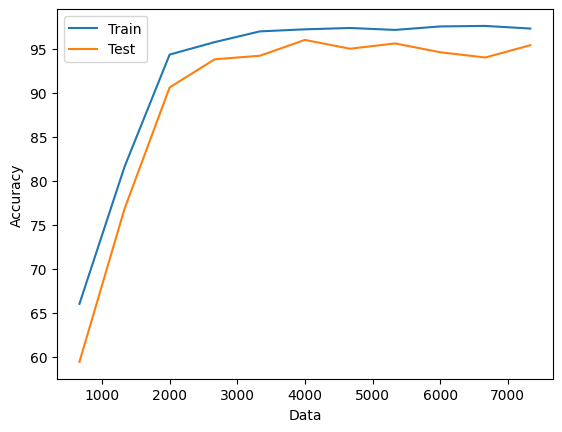

In [ ]:
data = [n_train * i/ratio for i in range(1, ratio)]

plt.plot(data, train_accuracies, label = "Train")
plt.plot(data, test_accuracies, label = "Test")

plt.xlabel("Data")
plt.ylabel("Accuracy")


plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
model.eval()

all_y = []
all_predictions = []

# Iterate over the dataset
for x, y in test_loader:
    x = x.to(device)

    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)

    all_y.extend(y.numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_y = np.array(all_y)
all_predictions = np.array(all_predictions)

conf_matrix = confusion_matrix(all_y, all_predictions, normalize = "true")

print(conf_matrix.round(decimals=2))

[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.95 0.04 0.   0.   0.   0.02 0.   0.  ]
 [0.   0.   0.   0.98 0.   0.02 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.98 0.   0.02 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.05 0.   0.   0.   0.   0.   0.95 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.98 0.02]
 [0.   0.02 0.   0.   0.02 0.   0.   0.04 0.09 0.83]]


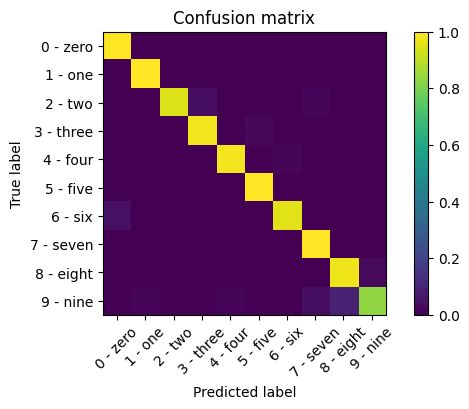

In [ ]:
classes =dataset_test.classes

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [ ]:
file_path = os.path.join(path_mount, path_data, subject)
np.save(file_path, test_accuracies)
print(file_path)